#Tutorial on EMA Workbench
Prepared by Jayendran V (IEOR, IIT Bombay)

## Tutorial Part 2
Part 2 is designed to teach you to do analysis using EMA workbench: define policy levers in addition to parameter uncertainties; perform experiments, and do feature scoring and scenario discovery. Refer to Part 1 tutorial on basic setup of EMA.
We will be using SEIR model of infectious diseases as an example.

## SEIR model with Policy
A basic model for the spread of a disease is the Susceptible, Exposed, Infected, Recovered (SEIR) model. This model splits a population into four groups. The SEIR model uses a system of ODE's to describe how these four groups change over time. The model uses only the contact ratio  β , the average incubation time  1/α  and the mean recovery time  1/γ .

Refer to the SEIR.ipynb for details about basic SEIR model.

### Policy setting
We would now like to explore how the policy of vaccination of susceptibles and/or quarantining infected people will help manage an epidemic. For illustrative purposes, we will consider static policy only, valid for entire simulation run, irrespective of the actual epidemic dynamics or other parameter values.
* Policy 1 on vaccination.  In this, $\epsilon$ fraction of Susceptibles are vaccinated per unit time. Once vaccinated, they are permanently immune to the disease and hence can be removed from the population pool.
* Policy 2 on quarantining.  In this, $\theta$ fraction of Infected are quarantined per unit time. The quanratined people do not contribute to spread of the disease. They recover at the same rate of $\gamma$.

The updated SIER model into a SEIQR model is shown below.


In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# The SEIQR differential equations.
def SEIQRmodel(y, t, N, beta, alpha, gamma, epsilon, theta):
  S, E, I, Q, R = y
  dS_dt = -beta*S*I/N - epsilon*S
  dE_dt = beta*S*I/N - alpha*E
  dI_dt = alpha*E - gamma*I - theta*I
  dQ_dt = theta*I - (gamma)*Q
  dR_dt = gamma*I + (gamma)*Q
  return dS_dt, dE_dt, dI_dt, dQ_dt, dR_dt

# The SEIQRsim is the simulation subroutine based on odeint
# This calls the SEIQRmodel function
def SEIQRsim(beta = 0.25,    # the effective contact+infectivity rate
           alpha = 1./4,    # rate of showing symptoms
           gamma = 1./10,   # the mean recovery rate
           epsilon = 0,   # POLICY1 the fraction of Susceptibles vaccinated per day; say ~500/day for a million population 
           theta = 0      # POLICY2 the fraction of Infected who are quarantined
           ):
  #Initial conditions
  N = 1 #Total Population taken as 1
  I0, E0, Q0, R0 = 10**-6, 0, 0, 0  #10^-6 is similar to saying 1 in a million has been infected. 
  S0 = N - I0 - R0 - E0
  # Initial conditions vector
  y0 = S0, E0, I0, Q0, R0

  #timepoints
  t = np.linspace(0, 200, 200)

  # Integrate/Simulate the SIR equations over the time grid, t.
  eqn = odeint(SEIQRmodel, y0, t, args=(N, beta, alpha, gamma, epsilon, theta))

  # Post processing
  S, E, I, Q, R = eqn.T
  peaktime = np.where(I==max(I))
  ptime = peaktime[0][0]
  Rinf = R[-1]
  #Return the SEIR timeseries, Max Infections and Time of Max Infections
  return S, E, I, Q, R, max(I), ptime, Rinf

In [2]:
# Libraries required need to be installed (if you are using Google Colab this has to be installed each time you run the page)
!pip -q install ema_workbench
# and other dependencies
#!pip -q install altair
#!pip -q install ipyparallel
#!pip -q install SALib
#!pip -q install platypus-opt
#!pip -q install pydot

     |████████████████████████████████| 23.7 MB 1.1 kB/s 


In [34]:
from ema_workbench import (Model, RealParameter, ScalarOutcome, TimeSeriesOutcome, 
                           Constant, CategoricalParameter)

mymodel = Model('SEIQRsim', function=SEIQRsim)  # instantiate the model

# specify uncertainties
mymodel.uncertainties = [RealParameter("beta", 0.15, 0.4), 
                       RealParameter("alpha", 1./7, 1./3),
                       RealParameter("gamma", 1./25, 1./10)]
# specify policy levers
# Categorical parameters will take on only the given setting
mymodel.levers = [CategoricalParameter('epsilon', [0, 0.0002, 0.0005]),
                  RealParameter('theta', 0, 0.15)]

# specify outcomes
mymodel.outcomes = [TimeSeriesOutcome('S'),
                    TimeSeriesOutcome('E'),
                    TimeSeriesOutcome('I'),
                    TimeSeriesOutcome('Q'),
                    TimeSeriesOutcome('R'),
                  ScalarOutcome('maxI'),
                  ScalarOutcome('ptime'),
                  ScalarOutcome('Rinf')]


The workbench treats sampling in the uncertainty space and the lever space separately. It will always execute a full factorial over the combination of the lever space and the uncertainty space.  Here we want that we want 1000 experiments, which will be executed for each of the 10 policy option, resulting in 10000 experiments

In [48]:
#Run the model using EMA for 1000 scenarios
from ema_workbench import ema_logging, perform_experiments, MultiprocessingEvaluator

#
# The **MultiprocessingEvaluator** is used to perform_experiments(). 
# This is to taking advantage of multiple cores (if any) to run the experiments.
#
ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(mymodel) as evaluator:
  results = evaluator.perform_experiments(scenarios=1000, policies=10)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 10 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


## Saving results in a file
We can use the `save_results()` function in EMA to store the results as a .tar.gz file. the results will be stores as .csv files as follows:
* `experiments metadata.csv`: Lists the paramter uncertainties and levers
* `outcomes metadata.csv`: List the outcomes of interest
* `experiments.csv`: Lists the specific combination values of inputs for each scenario used
* And one csv file for each of the outcome variables specified.

In [50]:
from ema_workbench import save_results
save_results(results, 'SEIQR1000Scenario10Policy.tar.gz')

#from ema_workbench import load_results
#results = load_results('SEIQR1000Scenario10Policy.tar.gz')

[MainProcess/INFO] results saved successfully to /content/SEIQR1000Scenario10Policy.tar.gz


**Reload results**

The data from experiments that is stored in csv format can be uploaded and used for analysis. The code for the same is shown above in commented form.  Will avoid the rerunning of the simulations; or interface the analysis with results got from other software.

## Visualising the Results
Now that we have run the model 10000 times, we can visualize the results.  We can also view the policy combinations selected

In [51]:

#We can view the poicy combinations selected
#The policy field is a policy-id created automatically
#
experiments, outcomes = results
experiments.groupby(['epsilon','theta', 'policy']).size()

epsilon  theta     policy
0.0000   0.005696  84        1000
         0.058580  81        1000
         0.069120  85        1000
         0.088316  86        1000
0.0002   0.017723  82        1000
         0.121718  88        1000
         0.148142  89        1000
0.0005   0.031209  83        1000
         0.090873  80        1000
         0.112049  87        1000
dtype: int64

In [52]:
#Display results
experiments, outcomes = results
experiments.head()

,alpha,beta,gamma,epsilon,theta,scenario,policy,model
0,0.183733,0.171017,0.099120,0.0005,0.090873,7500,80,SEIQRsim
1,0.252959,0.213542,0.090573,0.0005,0.090873,7501,80,SEIQRsim
2,0.223431,0.357035,0.096938,0.0005,0.090873,7502,80,SEIQRsim
3,0.236231,0.394669,0.043686,0.0005,0.090873,7503,80,SEIQRsim
4,0.300632,0.267346,0.066026,0.0005,0.090873,7504,80,SEIQRsim


A first simple visualization is to look at the dynamics over time. This is straightforward with the lines function. 

[MainProcess/INFO] maxI not shown because it is not time series data
[MainProcess/INFO] ptime not shown because it is not time series data
[MainProcess/INFO] Rinf not shown because it is not time series data
[MainProcess/INFO] maxI not shown because it is not time series data
[MainProcess/INFO] ptime not shown because it is not time series data
[MainProcess/INFO] Rinf not shown because it is not time series data


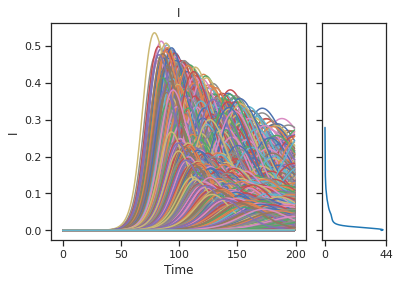

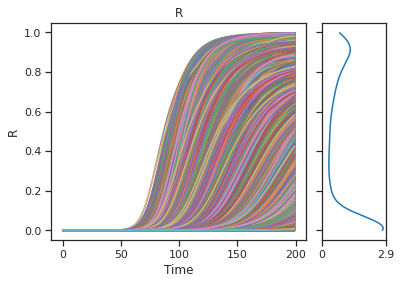

In [53]:
from ema_workbench.analysis import plotting, plotting_util

#show lines, and end state density
for outcometoshow in ['I', 'R']: 
  figure=plotting.lines(experiments, outcomes, outcomes_to_show=outcometoshow, density=plotting_util.Density.KDE)

## Pairwise plotting

A second useful visualization in this case is to look at the pair wise scatter plot for each of the scalar outcomes, using the pairs_scatter function.

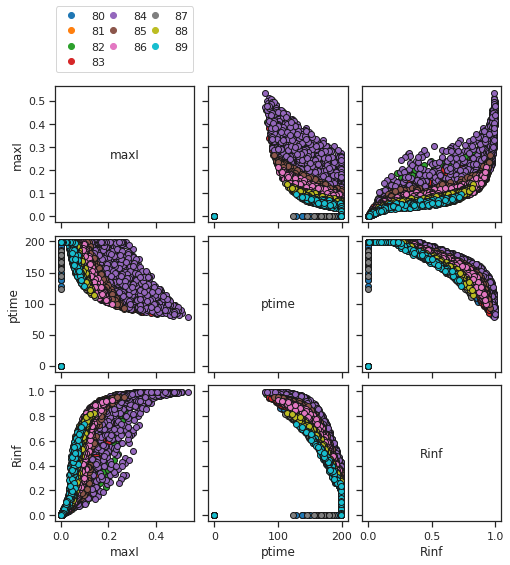

In [54]:
from ema_workbench.analysis import pairs_plotting

fig, axes = pairs_plotting.pairs_scatter(experiments, outcomes, outcomes_to_show=['maxI', 'ptime', 'Rinf'], group_by='policy',
                                         legend=True)
fig.set_size_inches(8,8)
plt.show()

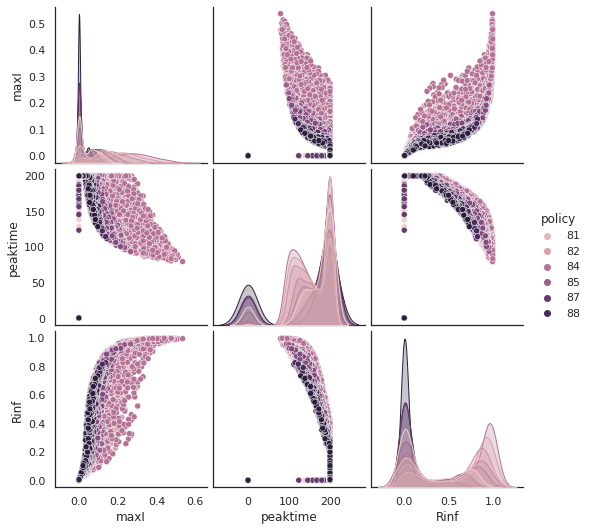

In [55]:
import pandas as pd
import seaborn as sns

import copy
experiments, outcomes = results
policy_column = experiments['policy']

data = pd.DataFrame(
    {'maxI': outcomes['maxI'],
     'peaktime': outcomes['ptime'],
     'Rinf': outcomes['Rinf'],
     'policy': policy_column
    })

sns.set(style="ticks", color_codes=True)    
with sns.axes_style('white'):
    sns.pairplot(data, hue='policy')
plt.show()


## More elaborate analyses
this includes Feature Scoring and Scenario Discovery 

## Feature scoring
Feature scoring is a family of machine learning techniques for identifying the relative importance of various features for a certain outcome or class of outcomes. Various feature-scoring techniques are included in the scikit –learn library. The workbench provides a convenient function that wraps some of the scikit-learn feature scoring techniques. As an example, we perform scoring on the Rinf at the end of the simulation. 

In [56]:
#Feature Scoring
from ema_workbench.analysis import feature_scoring

x = experiments
y = outcomes['Rinf']

fs, _ = feature_scoring.get_rf_feature_scores(x,y,mode=feature_scoring.RuleInductionType.REGRESSION)
fs

[MainProcess/INFO] model dropped from analysis because only a single category


,1
0,
beta,0.539877
theta,0.336522
gamma,0.057414
alpha,0.036086
policy,0.021944
epsilon,0.008157


The workbench comes with various feature scoring techniques. Above, we showed a simple random forest example. It also has extra trees technique for feature scoring instead

In [57]:
x = experiments
y = outcomes['Rinf']
fs, _ = feature_scoring.get_ex_feature_scores(x,y, 
                                              mode=feature_scoring.RuleInductionType.REGRESSION)
fs

[MainProcess/INFO] model dropped from analysis because only a single category


,1
0,
beta,0.537766
theta,0.231184
policy,0.111472
gamma,0.044969
epsilon,0.041449
alpha,0.033160


Or we can do a feature scoring for all the Scalar outcomes of interest, and then build a heatmap of the same

In [58]:
from ema_workbench.analysis.feature_scoring import get_feature_scores_all

x = experiments
y = outcomes.copy()

# The feature scoring is only for 1-D, i.e, Scalar outcomes. 
# Hence dropping the time vairant outcomes.
for v in ['S','E','I','Q','R']:
  del y[v]
print(y.keys())

fs_all = get_feature_scores_all(x, y, mode=feature_scoring.RuleInductionType.REGRESSION)
fs_all

[MainProcess/INFO] model dropped from analysis because only a single category


dict_keys(['maxI', 'ptime', 'Rinf'])


[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


,maxI,ptime,Rinf
alpha,0.017599,0.045791,0.032076
beta,0.273647,0.561064,0.536750
epsilon,0.043451,0.037143,0.039131
gamma,0.110965,0.100108,0.045622
policy,0.176334,0.123813,0.112645
theta,0.378005,0.132081,0.233778


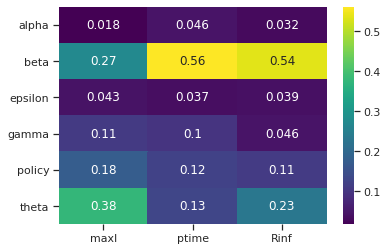

In [59]:
import seaborn as sns
sns.heatmap(fs_all, annot=True, cmap='viridis')
plt.show()

# Scenario discovery

A second analysis technique is to perform scenario discovery using either the Patient Rule Induction Method (PRIM) or Classification and Regression Trees (CART). For more details, see  https://waterprogramming.wordpress.com/2015/08/05/scenario-discovery-in-python/ and https://waterprogramming.wordpress.com/category/software/emaworkbench/



## Scenario discovery using PRIM
Here the application of PRIM is shown. In practice, the code would thus be executed in several steps and the user would make choices based on the results shown. The first step in applying scenario discovery is to specify which scenarios are of interest. Here, we use a simple classification. Any experiment where the Rinf at the end of the runtime is more than 0.25, is of interest. This means more than 25% of the population were infected with the disease.

Now, we need to instantiate the prim algorithm. We set "peeling alpha" to 0.1. The peeling alpha determines how much data is peeled off in each iteration of the algorithm. The lower the value, the less data is removed in each iteration. The minimium coverage threshold that a box should meet is set to 0.8. Next, we can use the instantiated algorithm to find a first box.


In [60]:
from ema_workbench.analysis import prim
experiments, outcomes = results
x = experiments.copy()
del x['policy'] #We are removing the 'policy_id' as a causation

y = outcomes['Rinf'] > 0.25 
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 10000 points remaining, containing 4944 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.1374, coverage: 0.2779126213592233, density: 1.0 restricted_dimensions: 2


In [61]:
print(y)

[False False  True ... False False False]


Let's investigate this first box is some detail. A first thing to look at is the trade off between coverage and density. The box has a convenience function for this called `show_tradeoff` 

The figure below shows the results for PRIM. First, we see the trade off between coverage and density.

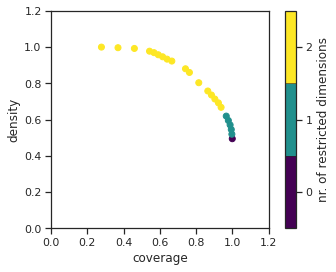

In [62]:
box1.show_tradeoff()
plt.show()

Since we are doing this analysis in a notebook, we can take advantage of the interactivity that the browser offers. A relatively recent addition to the python ecosystem is the library `altair`. Altair can be used to create interactive plots for use in a browser. Altair is an optional dependency for the workbench. If available, we can create the following visual.  

Here we can interactively explore the boxes associated with each point in the density coverage trade-off. It also offers mouse overs for the various points on the trade off curve.

In [63]:
box1.inspect_tradeoff()

alt.VConcatChart(...)

Given the id of each point, we can also use the workbench to manually inpect the peeling trajectory. Let's try box 15

coverage     0.64017
density     0.933628
id                15
mass           0.339
mean        0.933628
res_dim            2
Name: 15, dtype: object

         box 15                                          
            min       max                       qp values
theta  0.005696  0.089595  [-1.0, 4.903447809457536e-189]
beta   0.258793  0.399825                     [0.0, -1.0]



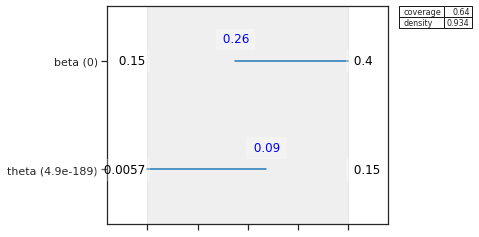

In [64]:
box1.inspect(15)
box1.inspect(15, style='graph')
plt.show()

We can get a more detailed view of what the box looks like. using a scatter plots for this.

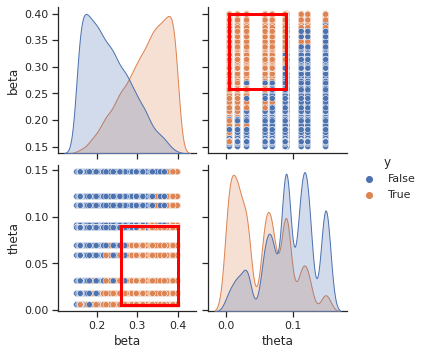

In [65]:
box1.show_pairs_scatter(15)
plt.show()

We can try Box 20 which has 3 dimensions

coverage     0.56527
density     0.975095
id                20
mass          0.2891
mean        0.975095
res_dim            4
Name: 20, dtype: object

         box 20                                         
            min       max                      qp values
theta  0.008738  0.102472  [-1.0, 1.12958773689707e-114]
gamma  0.040057  0.097021  [-1.0, 0.0015267700059511588]
beta   0.285553  0.399987                    [0.0, -1.0]
alpha  0.152603  0.333232   [0.026124991598564302, -1.0]



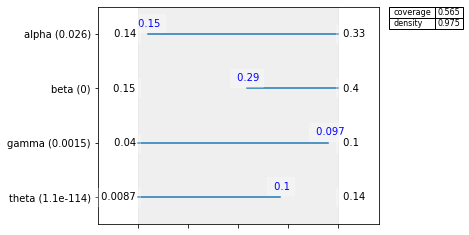

In [ ]:
box1.inspect(20)
box1.inspect(20, style='graph')
plt.show()

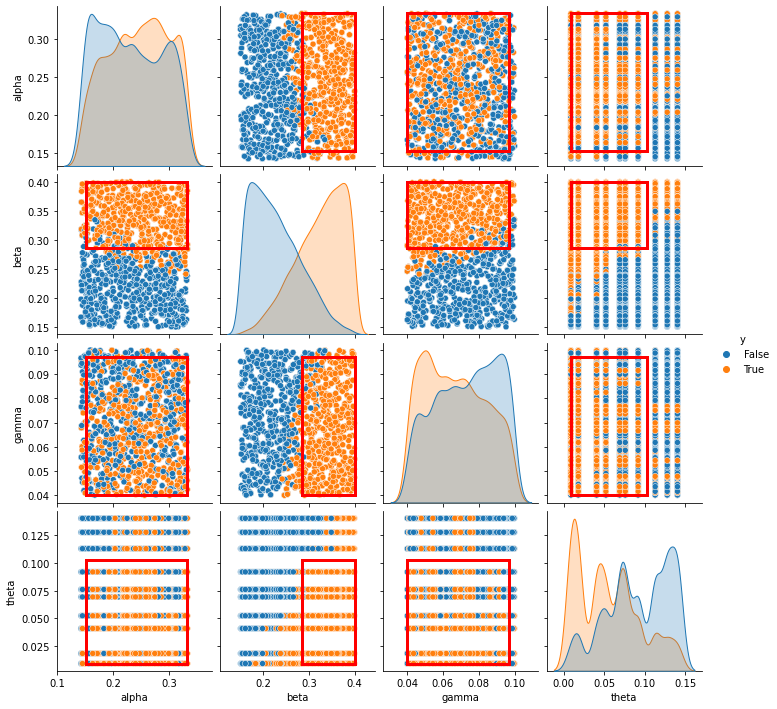

In [ ]:
box1.show_pairs_scatter(20)
plt.show()

##Dimensional stacking

Dimensional stacking is a more visual approach to scenario discovery. It involves two steps: identifying the most important uncertainties that affect system behavior, and creating a pivot table using the most influential uncertainties. Creating the pivot table involves binning the uncertainties. More details can be found in [Suzuki et al](https://www.onepetro.org/conference-paper/SPE-174774-MS). (2015)

[MainProcess/INFO] model dropped from analysis because only a single category


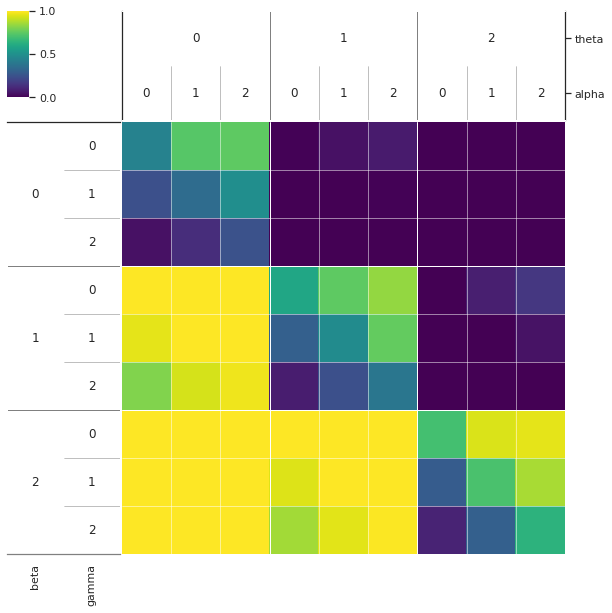

In [49]:
from ema_workbench.analysis import dimensional_stacking
 
experiments, outcomes = results
x = experiments.copy()
del x['policy'] #We are removing the 'policy_id' as a causation
y= outcomes['Rinf'] > 0.25
dimensional_stacking.create_pivot_plot(x,y, 2, nbins=3)
plt.show()

We can see from this visual that when $\beta$ is high, we have high value of Rinf, irrespective of the other parameters (mostly).
Suppose $\beta$ is in medium range, then, having medium to high $\theta$ can help keep the epidemic impact low. $\alpha$ and $\gamma$ on thier own doesn't impact the epidemic much. By playing around with an alternative number of bins, or different number of layers, patterns can be coarsened or refined.  In case you see white spaces instead of colored sqaures it means insufficient samples. Run more scenarios.

## Scenario discovery using CART

The way of interacting with CART is quite similar to how we setup the PRIM analysis. We import cart from the analysis package. We instantiate the algorithm, and next fit CART to the data. This is done via the `build_tree` method. After we have trained CART on the data, we can investigate its results. Just like PRIM, we can use `stats_to_dataframe` and `boxes_to_dataframe` to get an overview.

In [66]:
from ema_workbench.analysis import cart
experiments, outcomes = results
exp = experiments.copy()
cleaned_exp = exp.drop(labels=['model','policy','scenario','epsilon'], axis=1)

y = outcomes['Rinf'] > 0.25

cart_alg = cart.CART(cleaned_exp, y, mass_min=0.05)
cart_alg.build_tree()


In [67]:
cart_alg.stats_to_dataframe()

,coverage,density,res dim,mass
box 1,0.031149,0.230194,2,0.0669
box 2,0.154328,0.850613,2,0.0897
box 3,0.000607,0.005515,2,0.0544
box 4,0.040251,0.398000,2,0.0500
box 5,0.000000,0.000000,2,0.2050
box 6,0.005866,0.051786,2,0.0560
box 7,0.095874,0.948000,2,0.0500
box 8,0.100930,0.998000,3,0.0500
box 9,0.281149,1.000000,3,0.1390
box 10,0.159992,0.827406,2,0.0956


In [68]:
cart_alg.boxes_to_dataframe()

box 1               box 2  ...    box 11    box 12          
            min       max       min  ...       max       min       max
beta   0.150221  0.205761  0.205761  ...  0.341709  0.341709  0.399825
theta  0.005696  0.044895  0.005696  ...  0.148142  0.101461  0.148142
alpha  0.142980  0.333297  0.142980  ...  0.333297  0.142980  0.333297

[3 rows x 24 columns]

We can also view the classification tree.

In [ ]:
#!pip install graphviz
#!pip install pydot
#!pip install pydot-ng

In [ ]:
#
# The below code throws an error.  Haven't been able to figure out why
# Let me know if you can figure it out.
# 
fig = cart_alg.show_tree()
fig.set_size_inches((18, 12))
plt.show()

TypeError: ignored

The following work around can directly plot the decision tree.

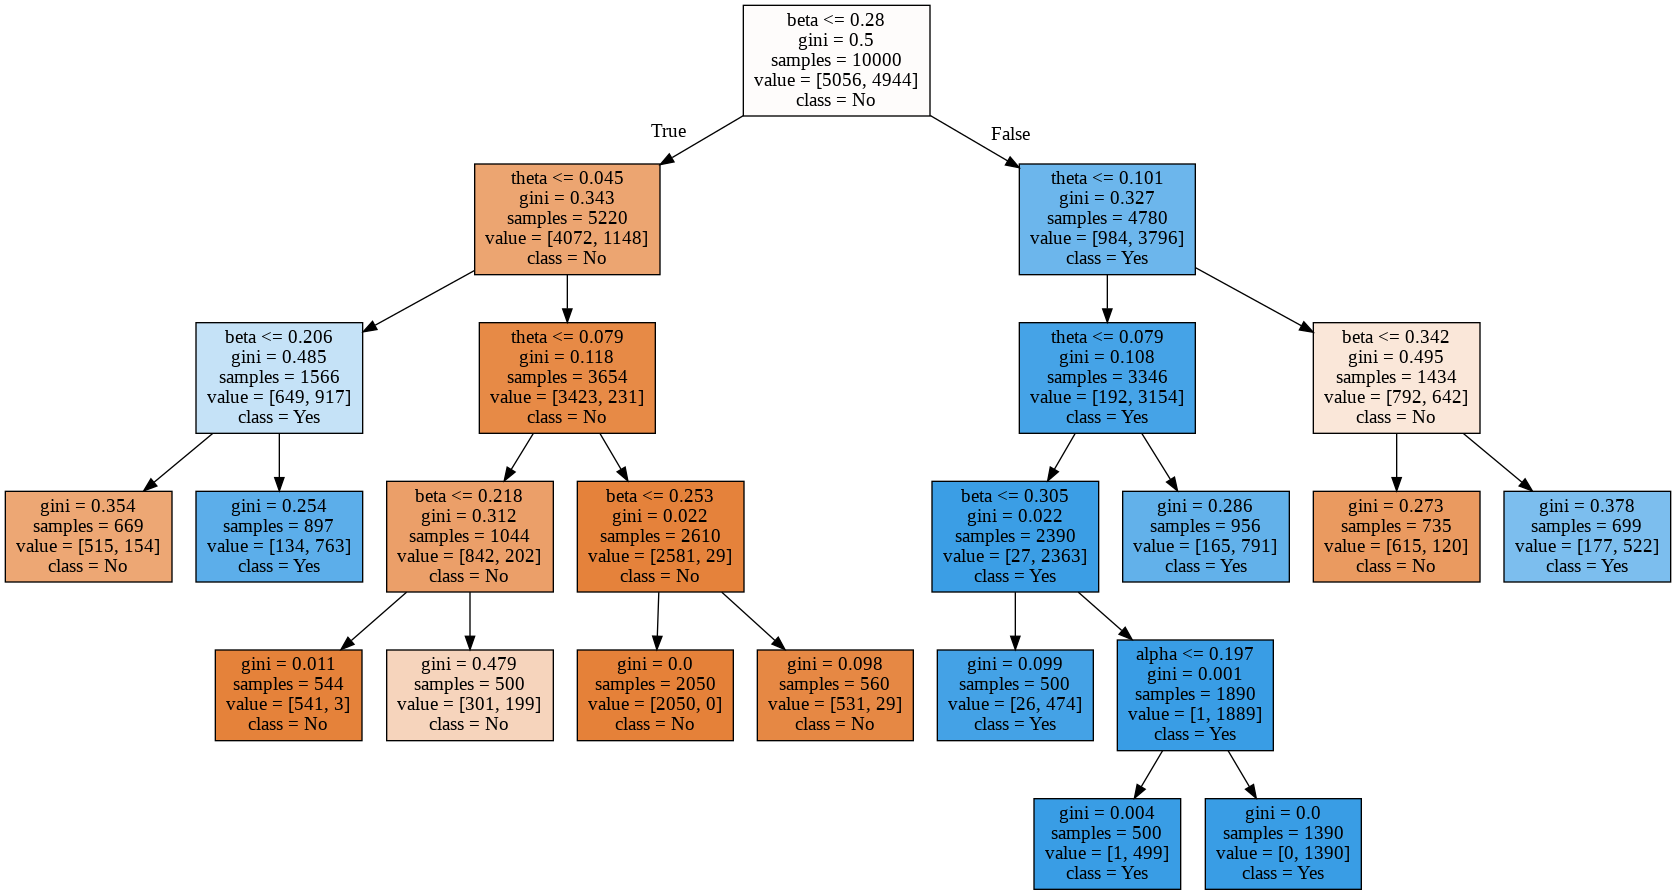

In [69]:
import pydotplus as pydtpls
import sklearn #sci-kit package
from IPython.display import Image

dot_data = sklearn.tree.export_graphviz(cart_alg.clf, feature_names=cart_alg.feature_names, filled=True, class_names=['No', 'Yes'])
graphs = pydtpls.graph_from_dot_data(dot_data)

img = graphs.create_png()
Image(img)

#Howework

1. How do $\beta$ and $\theta$ affect the severity and timing of the outbreak? To answer this do a visual analysis similar to SEIRBase.ipynb

2. Perform PRIM analysis to check the conditions for maxI > 0.25